In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import gc
import random
import time

from collections import deque
from IPython.display import clear_output

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.initializers import he_normal
from tensorflow.keras.optimizers import SGD

In [2]:
def create_model(seed = 666):
    init = he_normal(seed = seed)#اولیه که نمونه ها را از یک توزیع عادی کوتاه شده با محوریت 0 ترسیم می کند
    
    model = Sequential()
    model.add(Dense(64, input_shape = (2,), activation = 'relu', kernel_initializer = init))
    model.add(Dense(128, activation = 'relu', kernel_initializer = init))
    model.add(Dense(env.action_space.n, kernel_initializer = init))
    
    optimizer = SGD(learning_rate=1e-3)# در اینجا ما از SGD به عنوان بهینه ساز استفاده کردیم
    model.compile(optimizer = optimizer, loss = 'mse')#میانگین خطای مربع به عنوان عملکرد از دست دادن
    
    return model

In [4]:
env = gym.make('MountainCar-v0')

capacity = 5000 # Memory capacity
memory = deque(maxlen = capacity) # Defining memory
gamma = 0.99 # نرخ تخفیف برای پاداش آینده

# میزان اکتشاف
exploration_rate = 1 # شروع میزان اکتشاف
min_exploration_rate = 0.01 # حداقل نرخ اکتشاف
max_exploration_rate = 1 # حداکثر نرخ اکتشاف
exploration_decay_rate = 0.001

episodes_to_play = 15 # تعداد قسمتهای کامل برای بازی
batch_size = 32
update_counter = 0

#برای تجسم آینده
positions = []
rewards = []
exploration_rates = []
losses = []
val_losses = []

# تعریف سیاست و شبکه های هدف
policy_net = create_model()
target_net = create_model()
target_net.set_weights(policy_net.get_weights())

Episode: 15


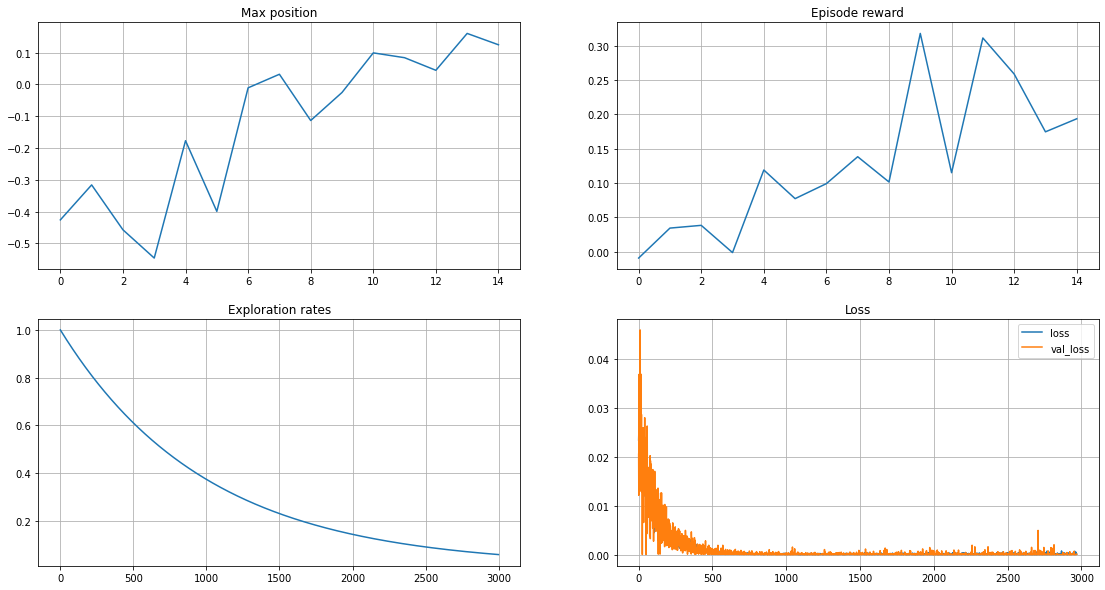

In [5]:
# اجرای episodes
for episode in range(episodes_to_play):  
    print("starting episode ", episode)
    max_position = -1.2 # حداکثر موقعیت رسیدن
    episode_reward = 0 # Track episode reward
    updated = False # آیا Net Target در این قسمت به روز شده است یا نه
    
    state = env.reset() # حالت اولیه را دریافت کنید
    
    #انجام شود episodes بازی کنید تا 
    while True:
        # میزان اکتشاف را تنظیم کنید
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(- exploration_decay_rate * (update_counter))
        
        # Store exploration rate in list for future visualization
        exploration_rates.append(exploration_rate)
        
        # با توجه به استراتژی حریصانه اقدام به انجام یک عمل
        exploration_rate_thresh = random.uniform(0, 1)        
        if exploration_rate_thresh < exploration_rate:
            action = env.action_space.sample()
        else:
            action = policy_net.predict(state.reshape((-1, 2)))
            action = np.argmax(action[0])
        
        # اجرای عمل
        new_state, reward, done, info = env.step(action)
        
        # اصلاح پاداش اگر یک چرخ دستی به 0.5 مسافت یا بالاتر برسد - پاداش اضافی می گیرد
        reward = 100*((np.sin(3 * new_state[0]) * 0.0025 + 0.5 * new_state[1] * new_state[1]) - (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
        if new_state[0] >= 0.5:
            reward += 1
        
        episode_reward += reward
        
        # Storing observation in memory
        memory.append([state, action, reward, new_state, done])
        
        # ردیابی حداکثر مسافت رسیده
        if new_state[0] > max_position:
            max_position = new_state[0]
        
        # آموزش سیاست
        if len(memory) >= batch_size:
            # گرفتن نمونه تصادفی از مشاهدات
            observations = random.sample(memory, batch_size)
            targets = []
            
            # حلقه از طریق تمام مشاهده در نمونه
            for obs in observations:
                state_, action_, reward_, new_state_, done_ = obs
                
                # هدف را با استفاده از سیاست پیش بینی کنید
                target = policy_net.predict(state_.reshape((-1, 2)))
                
                #Q-values به روز رسانی 
                if done_:
                    target[0, action_] = reward_
                else:
                    Q_optimal = max(target_net.predict(new_state_.reshape((-1, 2)))[0])
                    target[0, action_] = reward_ + Q_optimal * gamma
                targets.append(target[0])
            
            # تهیه داده برای آموزش سیاست
            observations = np.array([obs[0] for obs in observations], dtype = 'float32')
            targets = np.array(targets)
            
            # اموزش سیاست
            h = policy_net.fit(observations, targets, epochs = 1, verbose = 0, validation_split = 0.1)
            
            # ضرر و زیان را برای اهداف ذخیره کنید
            losses.append(h.history['loss'][0])
            val_losses.append(h.history['val_loss'][0])
        
        # Update target_net weights each 5 full episodes
        if (episode+1)%5 == 0 and not updated:
            print('Updating target_net weights')
            target_net.set_weights(policy_net.get_weights())
            updated = True
        
        update_counter += 1
        
        state = new_state
        
        if done:
            break
    print("episode ",episode, "----score:",episode_reward)
    # Store episode max position and reward for future visualization
    positions.append(max_position)
    rewards.append(episode_reward)
    
    # Plots
    clear_output(wait = True)
    print(f'Episode: {episode+1}')
    plt.figure(figsize = (19, 10))
    
    # Episode max position plot
    plt.subplot(221)
    plt.plot(range(len(positions)), positions)
    plt.grid(); plt.title('Max position')
    
    # Episode reward plot
    plt.subplot(222)
    plt.plot(range(len(positions)), rewards)
    plt.grid(); plt.title('Episode reward') 
    
    # Esploration rate for each frame
    plt.subplot(223)
    plt.plot(range(len(exploration_rates)), exploration_rates)
    plt.grid(); plt.title('Exploration rates')
    
    # Loss plot
    plt.subplot(224)
    plt.plot(range(len(losses)), losses, label = 'loss')
    plt.plot(range(len(losses)), val_losses, label = 'val_loss')
    plt.grid(); plt.legend(), plt.title('Loss')
    plt.show()
    
    gc.collect()

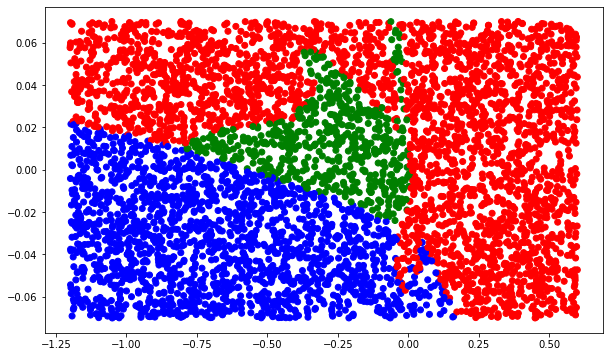

In [6]:
# Learned policy plot
X = np.random.uniform(-1.2, 0.6, 5000)
Y = np.random.uniform(-0.07, 0.07, 5000)
Z = []

colors = {0: 'b', 1: 'r', 2: 'g'}

for i in range(len(X)):
    pred = policy_net.predict(np.array([X[i], Y[i]]).reshape((-1, 2)))
    pred = np.argmax(pred)
    Z.append(colors[pred])
    
plt.figure(figsize = (10, 6))
plt.scatter(X, Y, c = Z)
plt.show()